In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

In [104]:
trainset = pd.read_csv('C:\\Users\\user\\Desktop\\02\\train.csv', na_values='-1')
testset = pd.read_csv('C:\\Users\\user\\Desktop\\02\\test.csv', na_values='-1')
# test.head()

In [105]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


- ind : indiviudal
- reg : registration
- car : self-explanatory
- calc : calculated 

<br>

- cat : categorical / 0 to n
- bin : binary (0 or 1)

In [106]:
('훈련셋 (행, 열) :', trainset.shape, '\n테스트셋 (행, 열):', testset.shape)

('훈련셋 (행, 열) :', (595212, 59), '\n테스트셋 (행, 열):', (892816, 58))

In [107]:
('Columns in train and not in test datset:', set(trainset.columns) - set(testset.columns))

('Columns in train and not in test datset:', {'target'})

<br>

## Introduction of metadata

- use : input, id, target
- type : nominal, interval, ordinal, binary
- preserve : True or False
- dataType : int, float, char
- category : ind, reg, car, calc

### 추가 isinstance()

In [108]:
data = []
for feature in trainset.columns:
    
    # role 정의
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # type 정의
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real' # interval
    elif trainset[feature].dtype == 'int':
        type = 'interger'
        
    # id를 제외하고 모두 True 로
    preserve = True
    if feature == 'id':
        preserve = False
    
    
    # 데이터 타입
    dtype = trainset[feature].dtype
    
    category = 'none'
    
    # Defining the category
    
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    # meta 데이터 담을 딕셔너리 생성
    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data,columns = ['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata.head()
        
    

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,individual
ps_ind_02_cat,input,categorical,True,float64,individual
ps_ind_03,input,categorical,True,int64,individual


In [109]:
trainset.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat     float64
ps_ind_03           int64
ps_ind_04_cat     float64
ps_ind_05_cat     float64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat     float64
ps_car_02_cat     float64
ps_car_03_cat     float64
ps_car_04_cat       int64
ps_car_05_cat     float64
ps_car_06_cat       int64
ps_car_07_cat     float64
ps_car_08_cat       int64
ps_car_09_cat     float64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

<br>

### categorical values check

In [110]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [111]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [112]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,15
3,input,real,22
4,target,binary,1


<br>

### Data anaylsis and statistics

#### Target variables

<Figure size 432x288 with 0 Axes>

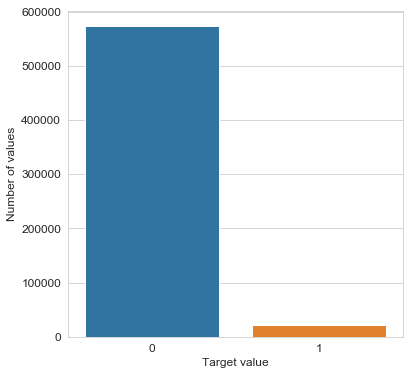

In [113]:
plt.figure()

fig, ax = plt.subplots(figsize=(6,6))

x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

sns.barplot(ax = ax ,x=x, y=y)
plt.ylabel('Number of values', fontsize = 12)
plt.xlabel('Target value', fontsize = 12)

plt.tick_params(axis = 'both', which = 'major', labelsize= 12)
plt.show()

<br>

### Real features
- trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real' # interval

In [114]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index

trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,487440.000000,595207.000000,595211.000000,595212.000000,552592.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.894047,2.346100,0.379947,0.813265,0.374691,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287643,0.404264,0.345413,0.832495,0.058300,0.224588,0.045610,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.061237,0.000000,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.633443,2.000000,0.316228,0.670867,0.350428,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.700000,0.300000,0.801561,3.000000,0.374166,0.765811,0.373497,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.900000,0.600000,1.083974,3.000000,0.400000,0.906190,0.398121,3.605551,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


<br>

### 추가 : pow

- 근데 이걸 왜 하는거지?

In [115]:
(pow(trainset['ps_car_12'] * 10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [116]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


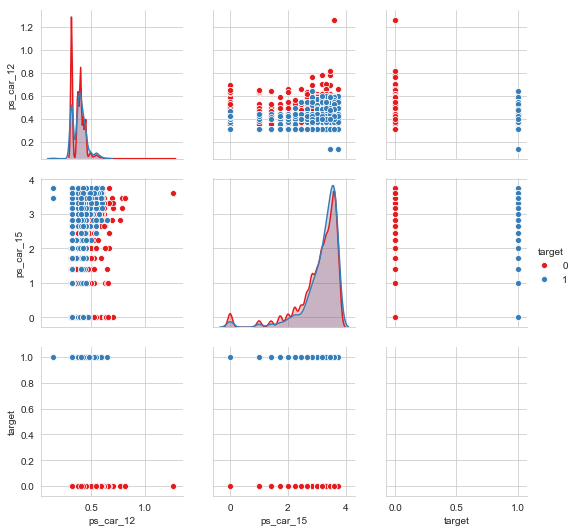

In [117]:
sample = trainset.sample(frac = 0.05)
var = ['ps_car_12', 'ps_car_15', 'target']

sample = sample[var]
sns.pairplot(sample, hue= 'target', palette = 'Set1', diag_kind = 'kde')
plt.show()


<br>

### 추가
- i 값의 범위를 지정해주지 않았더니 range 오류 발생
- i 값의 범위를 max 값인 12로 지정 해줌

<Figure size 432x288 with 0 Axes>

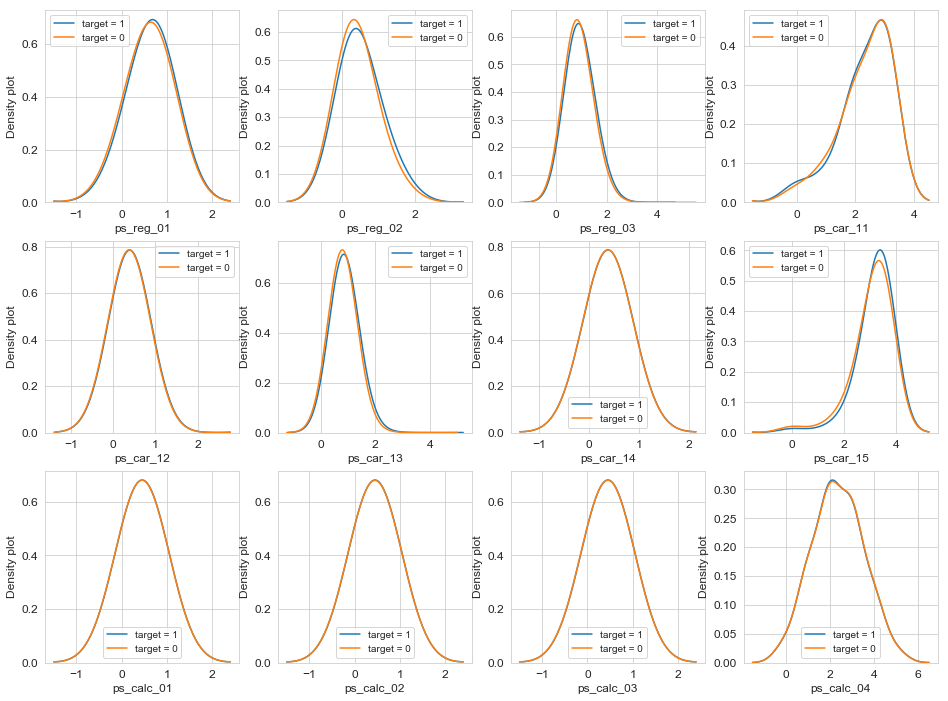

In [118]:
var = metadata[ (metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize = (16, 12))

for feature in var:
    i += 1
    if i <= 12:
        plt.subplot(3, 4, i)
        sns.kdeplot(t1[feature], bw = 0.5, label = 'target = 1')
        sns.kdeplot(t0[feature], bw = 0.5, label = 'target = 0')
        plt.ylabel('Density plot', fontsize = 12)
        plt.xlabel(feature, fontsize = 12)
        locs, labels = plt.xticks()
    
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
    

    else:
        break
plt.show()

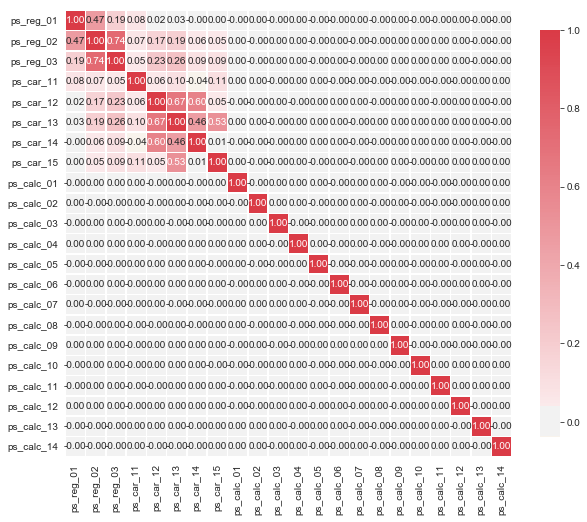

In [119]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    cmap = sns.diverging_palette(50, 10, as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax = 1.0, center = 0, fmt = '.2f',
               square = True, linewidths = .5, annot = True, cbar_kws = {'shrink': .75})
    plt.show()

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

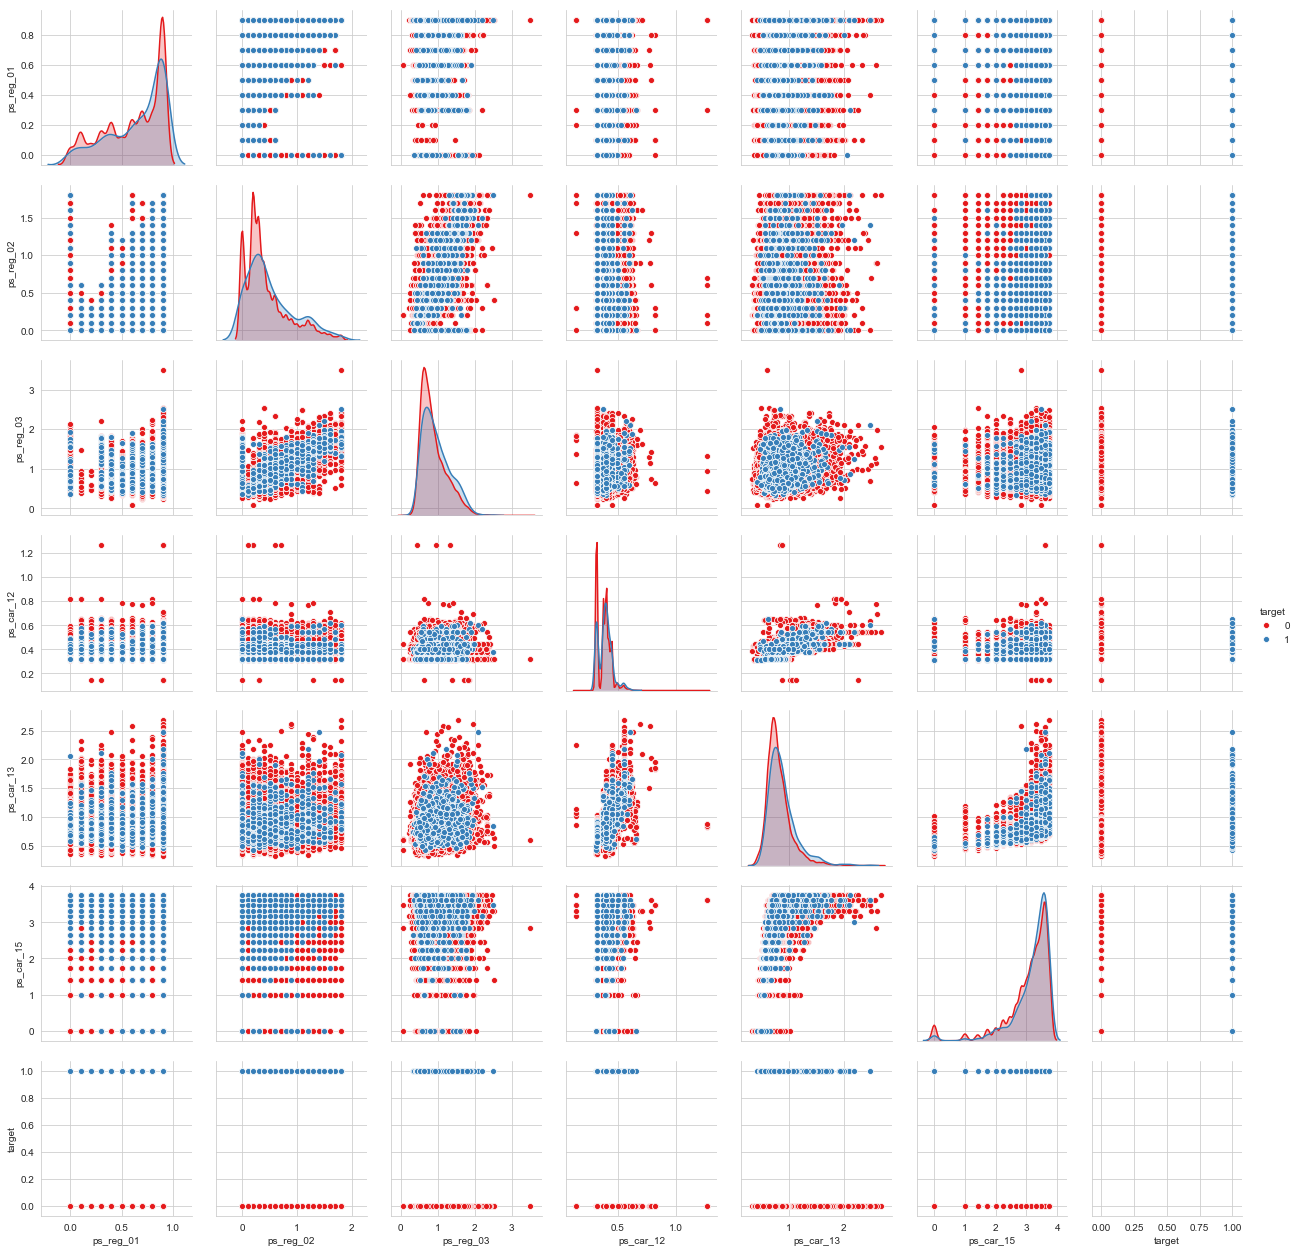

In [120]:
sample = trainset.sample(frac = 0.05)

var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']

sample = sample[var]
sns.pairplot(sample, hue = 'target', palette = 'Set1', diag_kind = 'kde')

plt.show()

<br>

### Binary features

In [121]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_01,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [122]:
trainset['target'].dtypes

dtype('int64')

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000023A1A3EAF60> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\legend.py:798: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000023A1A3EAF60> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


<Figure size 432x288 with 0 Axes>

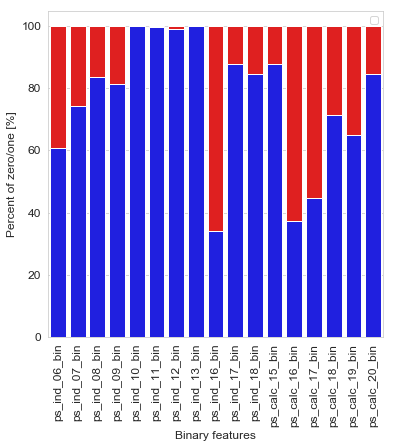

In [123]:
bin_col = [col for col in trainset.columns if '_bin' in col]

zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((trainset[col] ==0).sum() / int(trainset.shape[0])*100)
    one_list.append((trainset[col] == 1).sum() / trainset.shape[0] *100)
    
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))

p1 = sns.barplot(ax = ax, x = bin_col, y =zero_list, color = 'blue')
p2 = sns.barplot(ax = ax, x = bin_col, y = one_list, bottom = zero_list, color = 'red')

plt.ylabel('Percent of zero/one [%]', fontsize = 12)
plt.xlabel('Binary features', fontsize = 12)

locs, labels = plt.xticks()
plt.setp(labels, rotation = 90)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)

plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

<Figure size 432x288 with 0 Axes>

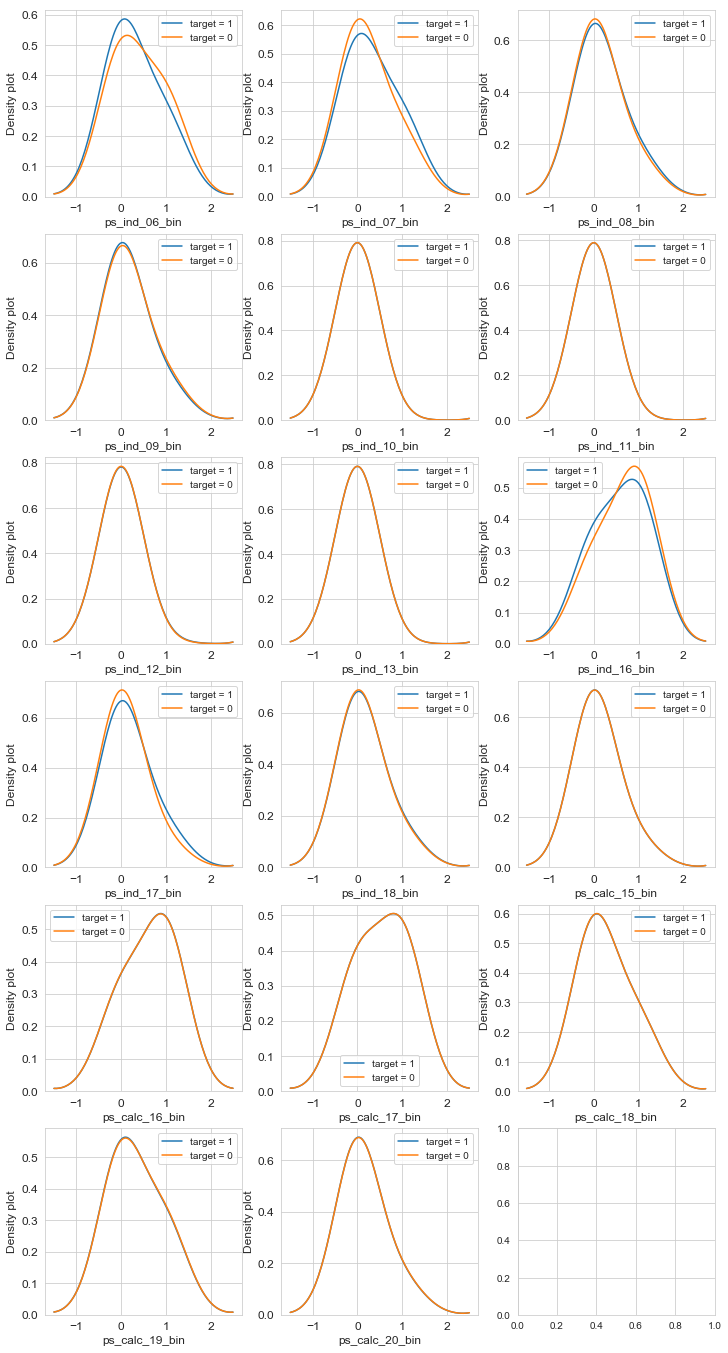

In [124]:
var = metadata[ (metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize = (12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw = 0.5, label = 'target = 1')
    sns.kdeplot(t0[feature], bw = 0.5, label = 'target = 0')
    plt.ylabel('Density plot', fontsize = 12)
    plt.xlabel(feature, fontsize = 12)
    
    locs, labels = plt.xticks()
    
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
plt.show()

<br>

### Categorical features

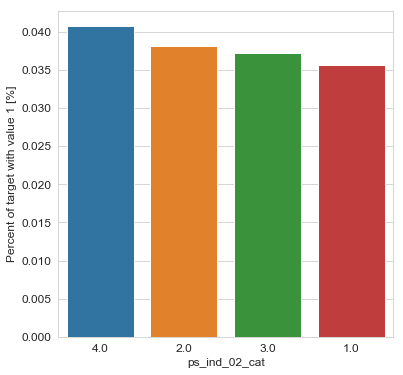

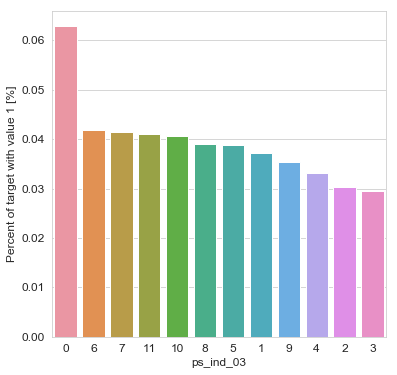

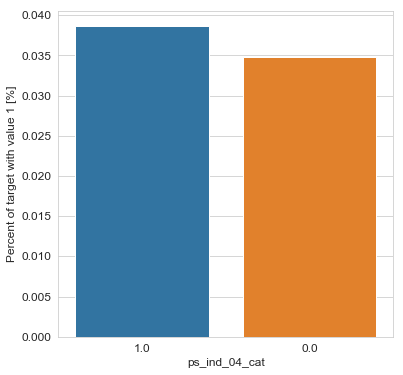

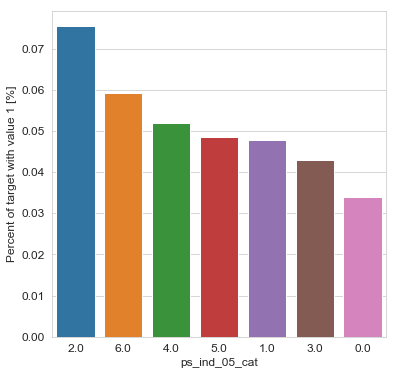

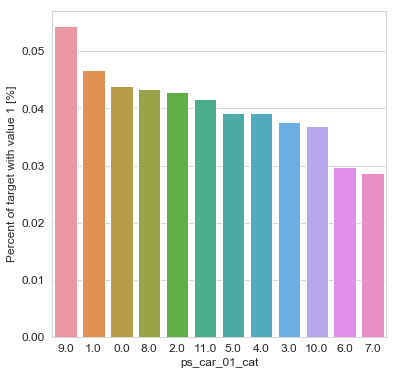

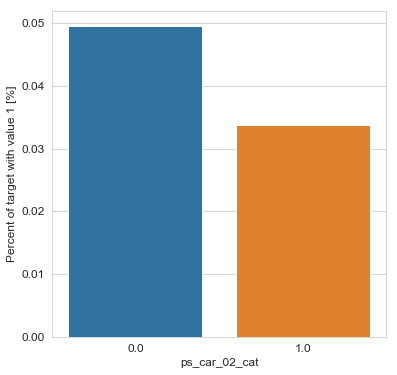

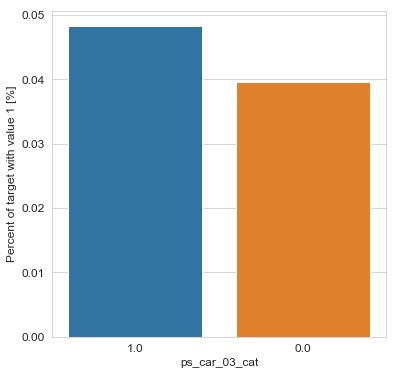

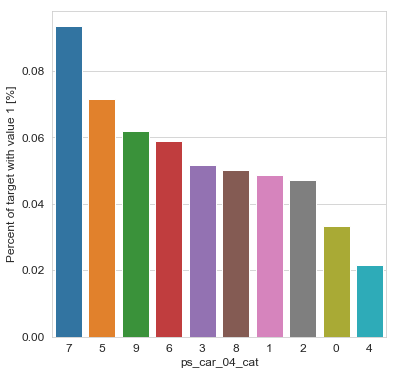

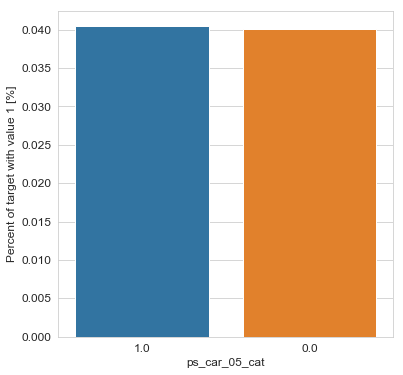

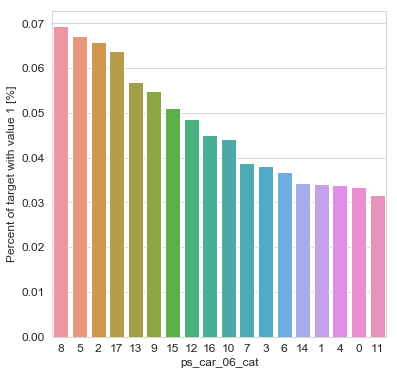

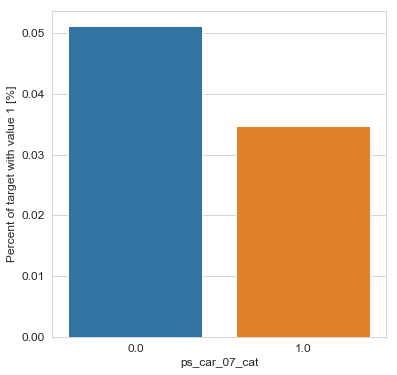

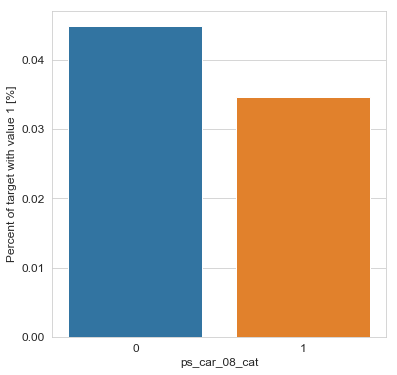

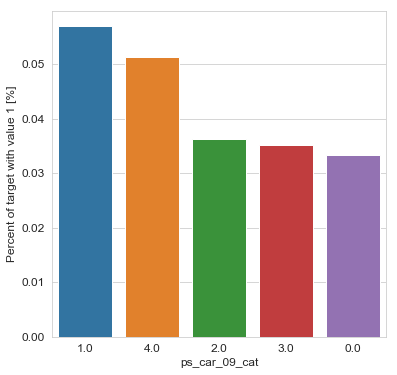

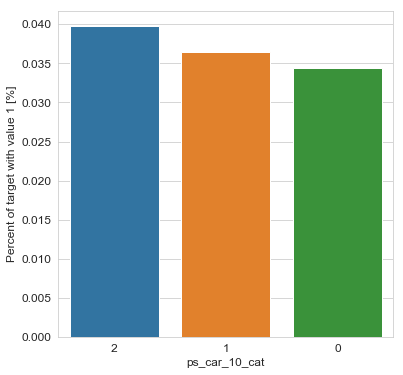

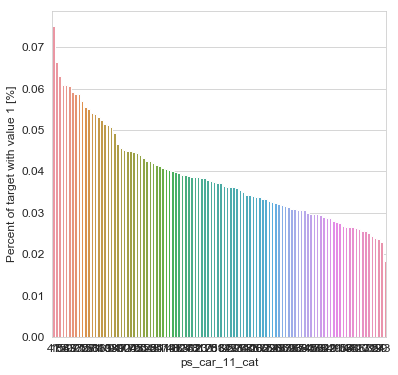

In [125]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize = (6,6))
    
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index = False).mean()
    cat_perc.sort_values(by = 'target', ascending = False, inplace = True)
    
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order = cat_perc[feature])
    
    plt.ylabel('Percent of target with value 1 [%]', fontsize = 12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.show()

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 432x288 with 0 Axes>

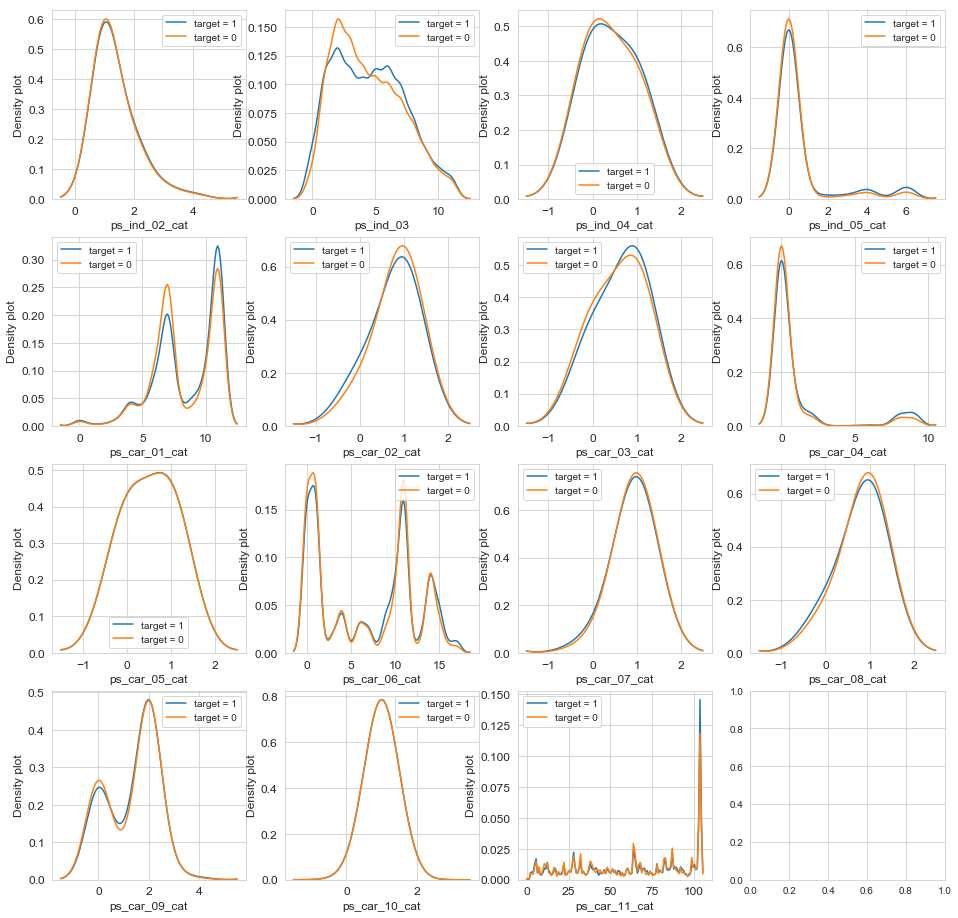

In [126]:
var = metadata[ (metadata.type == 'categorical') & (metadata.preserve)].index

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

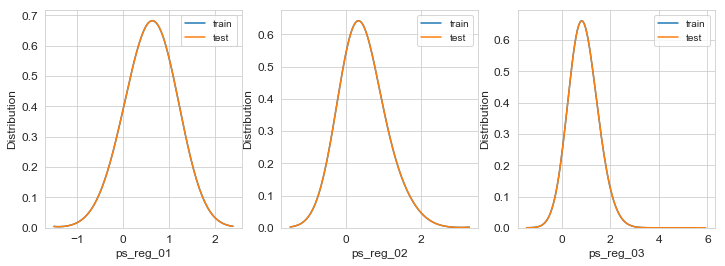

In [127]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    if i <=3:
        plt.subplot(1,3,i)
        sns.kdeplot(trainset[feature], bw=0.5, label="train")
        sns.kdeplot(testset[feature], bw=0.5, label="test")
        plt.ylabel('Distribution', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
        plt.tick_params(axis='both', which='major', labelsize=12)
    else:
        break
plt.show()

<Figure size 432x288 with 0 Axes>

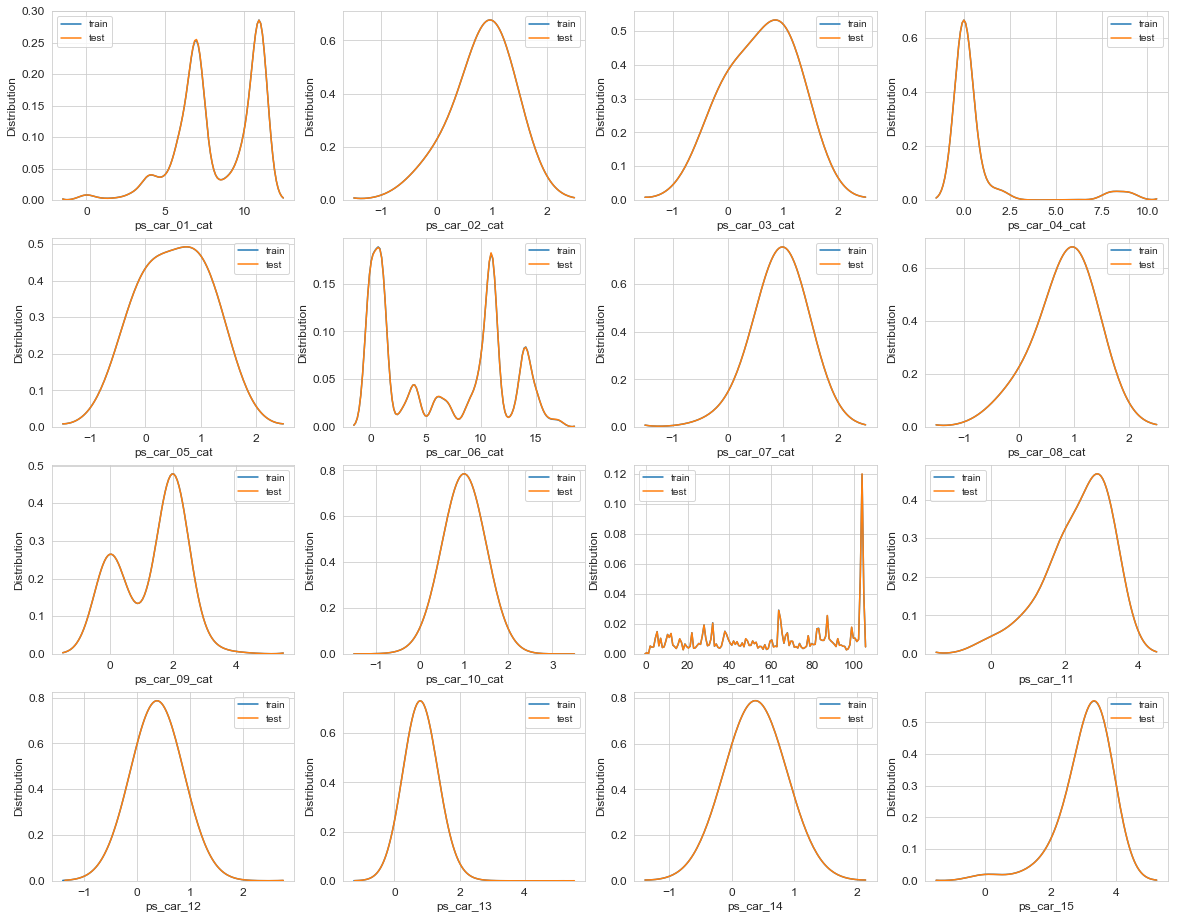

In [128]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

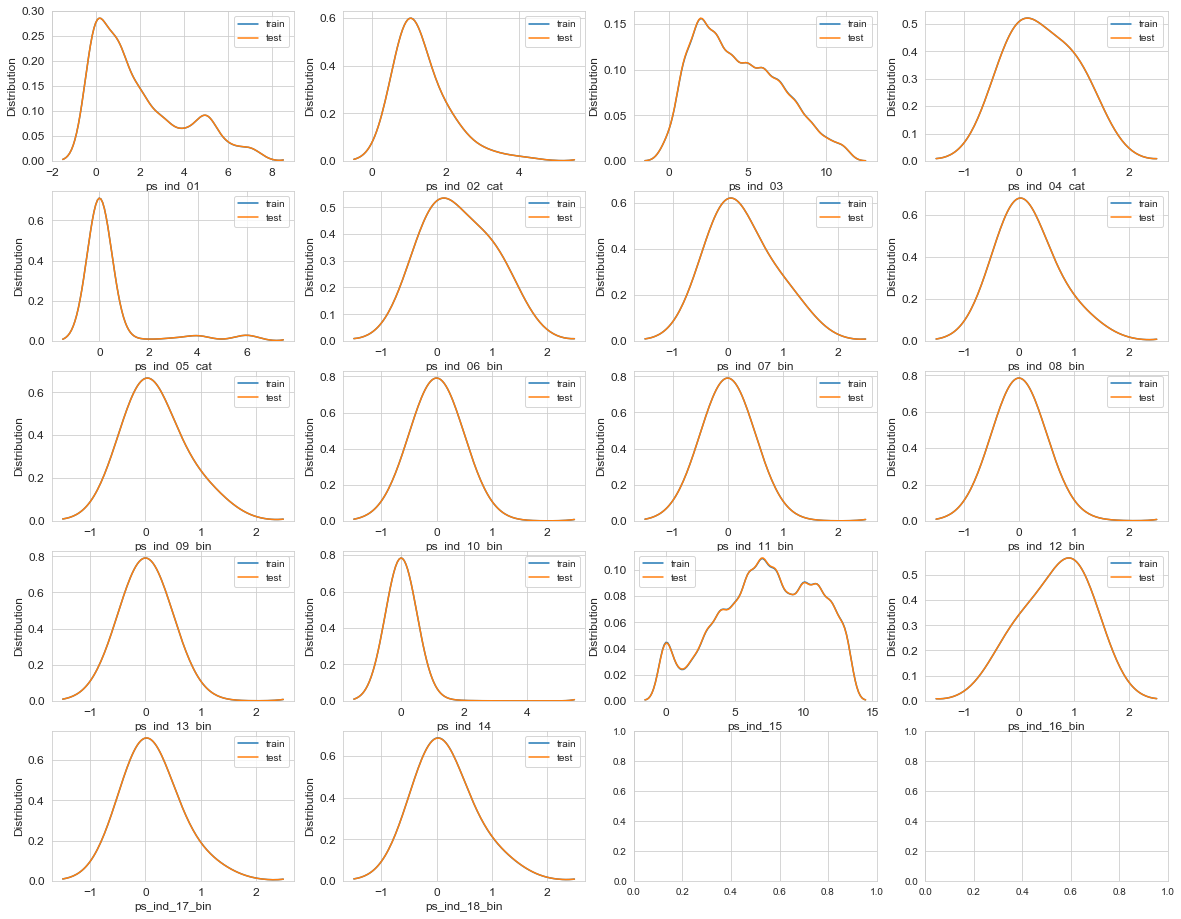

In [129]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

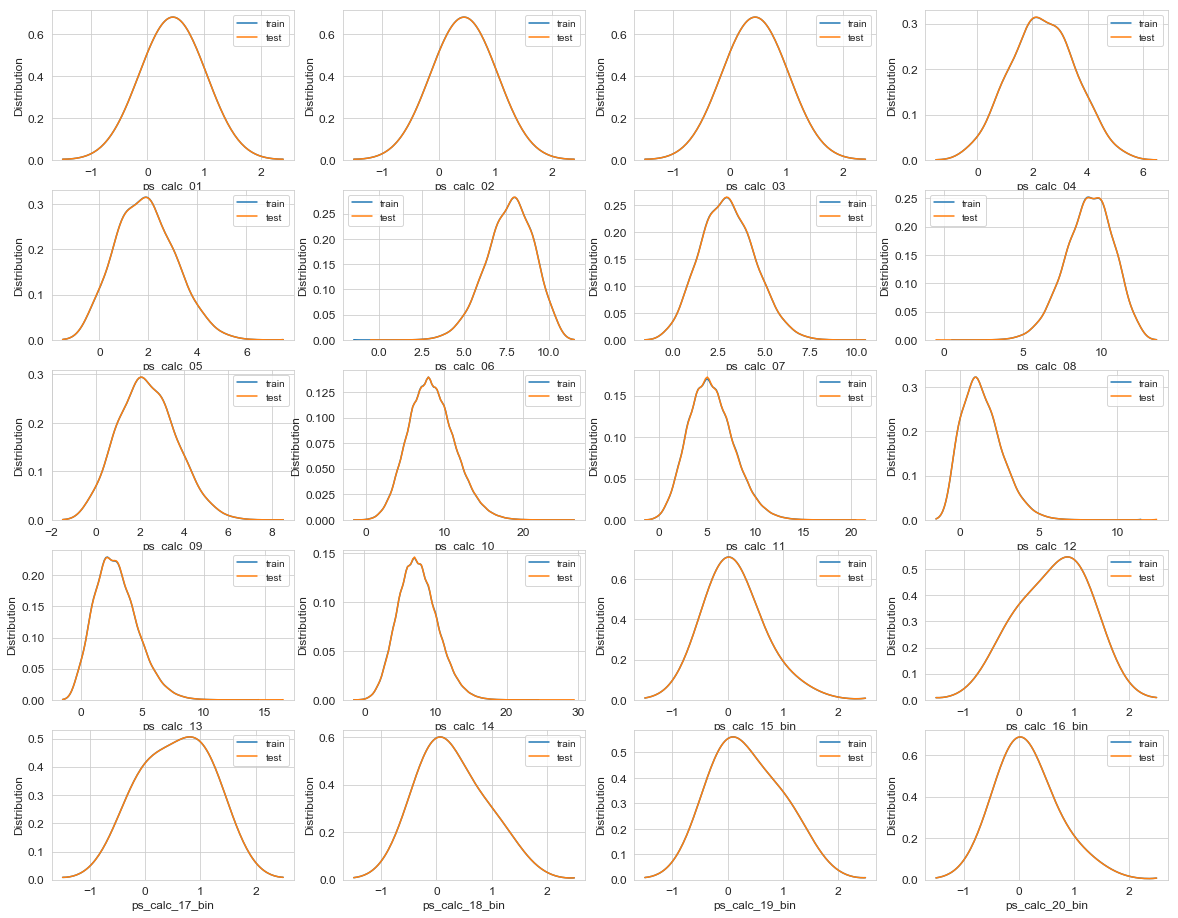

In [130]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<br>

### Check data quality

In [131]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[(trainset[feature] == -1 ) ][feature].count()
    
    if missings > 0 :
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))        

In total, there are 0 variables with missing values


In [132]:
trainset.ps_reg_03

0         0.718070
1         0.766078
2              NaN
3         0.580948
4         0.840759
5         2.332649
6         0.617454
7         0.607248
8         0.901388
9         2.316652
10        0.795692
11        0.378319
12        0.548293
13        0.684197
14        1.052972
15             NaN
16        0.699553
17        0.810864
18             NaN
19        0.402337
20        1.372725
21        0.955903
22        0.742041
23             NaN
24        0.587367
25             NaN
26        0.666146
27        1.034408
28             NaN
29        1.155692
            ...   
595182    0.941077
595183    0.953612
595184    0.626997
595185    0.500000
595186    1.006231
595187    0.910014
595188         NaN
595189    0.808934
595190         NaN
595191    0.912414
595192    0.649519
595193    1.362213
595194         NaN
595195    0.629980
595196    0.852936
595197    1.332291
595198    0.839643
595199    0.779022
595200    0.392110
595201    0.812404
595202    0.366572
595203    1.

In [133]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis =1)
testset = testset.drop(col_to_drop, axis =1)

In [135]:
vars_to_drop =['ps_car_03_cat', 'ps_car_05_cat']

trainset.drop(vars_to_drop, inplace = True, axis =1)
testset.drop(vars_to_drop, inplace = True, axis =1)
metadata.loc[(vars_to_drop), 'keep'] = False

In [139]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

<br>

#### ps_car_11 값을 인코딩된 값으로 대체하기
- target_encode 함수 사용해서 ps_car_11_cat 값은 train과 test 내의 encoded value로 대체

In [140]:
train_encoded, test_encoded = target_encode(trainset['ps_car_11_cat'],
                                           testset['ps_car_11_cat'],
                                           target = trainset.target,
                                           min_samples_leaf = 100,
                                           smoothing = 10,
                                           noise_level = 0.01)

In [141]:
train_encoded.head()

0    0.038416
1    0.023805
2    0.031366
3    0.044403
4    0.026037
Name: ps_car_11_cat_mean, dtype: float64

In [143]:
trainset['ps_car_11_cate_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis =1, inplace = True)

KeyError: "['ps_car_11_cat'] not found in axis"

In [144]:
metadata.loc['ps_car_11_cat', 'keep'] = False
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis = 1, inplace = True)

<br>

### 클래스 균형 맞추기

In [146]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


<br>

### -1 을 nan 로 대체

In [147]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

In [148]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

In [150]:
trainset.columns

Index([               'id',            'target',         'ps_ind_01',
               'ps_ind_03',     'ps_ind_06_bin',     'ps_ind_07_bin',
           'ps_ind_08_bin',     'ps_ind_09_bin',     'ps_ind_10_bin',
           'ps_ind_11_bin',     'ps_ind_12_bin',     'ps_ind_13_bin',
               'ps_ind_14',         'ps_ind_15',     'ps_ind_16_bin',
           'ps_ind_17_bin',     'ps_ind_18_bin',         'ps_reg_01',
               'ps_reg_02',         'ps_reg_03',         'ps_car_11',
               'ps_car_12',         'ps_car_13',         'ps_car_14',
               'ps_car_15', 'ps_car_11_cate_te',                 1.0,
                       2.0,                 3.0,                 4.0,
                       0.0,                 1.0,                 0.0,
                       1.0,                 2.0,                 3.0,
                       4.0,                 5.0,                 6.0,
                       0.0,                 1.0,                 2.0,
                    

In [151]:
# 사용하지 않은 칼럼 삭제 - id, target

id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis =1)
testset = testset.drop(['id'], axis =1)


In [152]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


## Prepare the model

### Ensable class for cross validation and ensamble
- Prepare an Ensamble class to split the data in KFolds, train the models and ensamble the results.

- The class has an init method (called when an Ensamble object is created) that accepts 4 parameters:

`self` - the object to be initialized


`n_splits` - the number of cross-validation splits to be used


`stacker` - the model used for stacking the prediction results from the trained base models


`base_models` - the list of base models used in training


A second method, fit_predict has four functions:

- split the training data in n_splits folds;

- run the base models for each fold;

- perform prediction using each model;

- ensamble the resuls using the stacker;

In [153]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [154]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [155]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [156]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))

In [ ]:
y_prediction = stack.fit_predict(trainset, target_train, testset)        


Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63648 [gini]: 0.27297
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63910 [gini]: 0.27820
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63682 [gini]: 0.27365
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63746 [gini]: 0.27492
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.64036 [gini]: 0.28072
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63708 [gini]: 0.27416
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63562 [gini]: 0.27124
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63768 [gini]: 0.27536
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63450 [gini]: 0.26899
Base model 4: fit XGBClassifier model | fold 1


In [ ]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)